# Book Recommender System by Anuj Wagle


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
import graphlab as gl
import implicit as im
from sklearn.cross_validation import train_test_split
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [2]:
#Reading users file:
users = pd.read_csv('data/BX-Users.csv', sep=';',low_memory=False, 
 encoding='latin-1',error_bad_lines=False,)
users.columns= ["userID","location","age"]


#Reading ratings file:
ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';',low_memory=False, 
 encoding='latin-1',error_bad_lines=False)
ratings.columns = ["userID","iSBN","bookRating"]


#Reading books file:

books = pd.read_csv('data/BX-Books.csv', sep=';', 
 encoding='latin-1',error_bad_lines=False,low_memory=False)
books.columns= ["iSBN","bookTitle","bookAuthor","yearOfPublication","publisher","ImageURLS","ImageURLM","ImageURLL"]


Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9
Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9
Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9
Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9



In [3]:
users.head()

,userID,location,age
0,1,"nyc, new york, usa",nan
1,2,"stockton, california, usa",18.000
2,3,"moscow, yukon territory, russia",nan
3,4,"porto, v.n.gaia, portugal",17.000
4,5,"farnborough, hants, united kingdom",nan


In [4]:
ratings.head()


,userID,iSBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
books.head()

,iSBN,bookTitle,bookAuthor,yearOfPublication,publisher,ImageURLS,ImageURLM,ImageURLL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


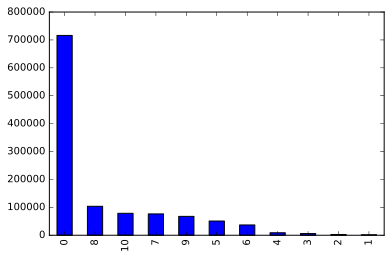

In [6]:
ratings.bookRating.value_counts().plot(kind='bar')



# Cleaning Up

In [7]:
ratings.iSBN=ratings.iSBN.str.replace(r'[^\w\d]+', '')
books.iSBN=books.iSBN.str.replace(r'[^\w\d]+', '')


,userID,iSBN,bookRating
1,276726,0155061224,5.000
3,276729,052165615X,3.000
4,276729,0521795028,6.000
6,276736,3257224281,8.000
7,276737,0600570967,6.000


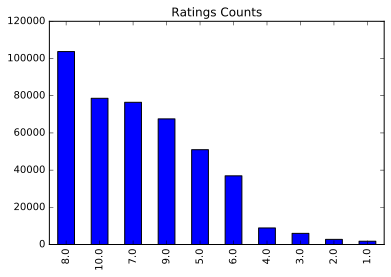

In [8]:
ratings.replace(["NaN", 'NaT','nan'], np.nan, inplace = True)
ratings=ratings.dropna()
avg_ratings = ratings.groupby('iSBN')['bookRating'].mean().round().astype(np.int8)
ratings.loc[ratings['bookRating'] == 0, 'bookRating'] = ratings.loc[ratings['bookRating'] == 0, 'bookRating'].map(avg_ratings)
ratings.loc[ratings['bookRating']==np.nan, 'bookRating'] = ratings.loc[ratings['bookRating']==np.nan, 'bookRating'].map(avg_ratings)
ratings.bookRating.value_counts().plot(kind='bar')
plt.title("Ratings Counts")
ratings=ratings.dropna()
ratings.head()

Checking for null values to make sure

In [9]:
ratings.loc[ratings['bookRating'].isnull(), 'bookRating']
#ratings.userID.unique()


Series([], Name: bookRating, dtype: float64)

In [10]:
users.age.describe()


count   168096.000
mean        34.751
std         14.428
min          0.000
25%         24.000
50%         32.000
75%         44.000
max        244.000
Name: age, dtype: float64

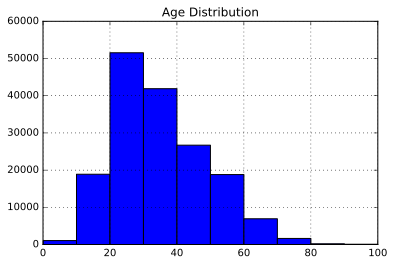

In [11]:
users.age.hist(bins=[0,10,20,30,40,50,60,70,80,90,100])
plt.title("Age Distribution")


Major Age Group is 20-30. 

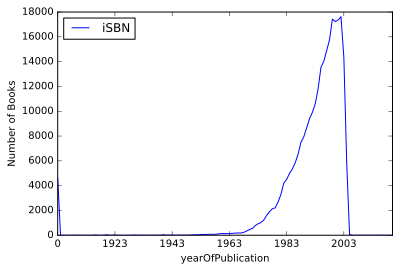

In [12]:

book_grouped=pd.DataFrame(books.groupby('yearOfPublication')['iSBN'].count())
po=book_grouped.plot()
po.set_ylabel("Number of Books")


We can see that there are number of books which have dates set as 0 and also we can see the increase in number of books plublished each year. Since we do not need the year of publicattion for our recommender system we do not need to drop any of the books.

# Popularity Based Recommendation

In [13]:
rating_count=pd.DataFrame(ratings.groupby('iSBN',as_index=False)['bookRating'].count())
avg_rating=pd.DataFrame(ratings.groupby('iSBN',as_index=False)['bookRating'].mean())
avg_and_count=avg_rating.merge(rating_count, on='iSBN',how="inner")
avg_and_count.columns=["iSBN","avg_rating","ratings_count"]
avg_and_count=avg_and_count.sort_values('ratings_count',ascending=False)
avg_and_count.head()

,iSBN,avg_rating,ratings_count
26254,0316666343,8.185,707
132403,0971880107,4.391,581
44837,0385504209,8.426,488
22283,0312195516,8.183,383
90077,0679781587,8.408,333


In [14]:
most_rated=books.loc[books.iSBN.isin(list(avg_and_count.head()['iSBN']))]
most_rated

,iSBN,bookTitle,bookAuthor,yearOfPublication,publisher,ImageURLS,ImageURLM,ImageURLL
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...


In [15]:
from IPython.display import Image
from IPython.display import display
covers=[Image(url=most_rated.iloc[k].ImageURLL) for k in range(4)]
display(*covers)


# Personalized Recommender( Item-Item Collaboration Filtering)

 ## Splitting Training and Testing Data using GraphLab

In [16]:
train_data, test_data = train_test_split(ratings, test_size = 0.20, random_state=0)
print "Training data length=",len(train_data),"Original data length=",len(books)
train_data.head()
test_data.head()

Training data length= 346936 Original data length= 271360


,userID,iSBN,bookRating
543502,130554,055356756X,6.000
891363,215091,0553231804,9.000
1120786,268932,0770426190,8.000
974898,235105,0312104235,8.000
874539,211692,0140430148,10.000


In [17]:
len(train_data.userID.unique())

68283

In [18]:
test_data_SF=gl.SFrame(test_data)


This non-commercial license of GraphLab Create for academic use is assigned to aw7464@mun.ca and will expire on November 20, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\anujw\AppData\Local\Temp\graphlab_server_1511894271.log.0


## Training The Model

In [19]:
train_data_SF=gl.SFrame(train_data)

personalized_model = gl.item_similarity_recommender.create(train_data_SF,user_id="userID",item_id="iSBN",target='bookRating')

Recsys training: model = item_similarity

Preparing data set.

Data has 346936 observations with 68283 users and 158866 items.

Data prepared in: 0.593611s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.963ms                        | 8.75       |

| 17.003ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.97s                               | 0                | 0               |

| 2.97s                               | 54               | 86021           |

| 5.14s                               | 58               | 92385           |

| 8.71s                               | 83.5             | 132899          |

| 10.03s                              | 91.25            | 145209          |

| 10.89s                              | 96               | 152651          |

| 13.18s                              | 100              | 158866          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 14.3377s

# Saving the Model

In [20]:
personalized_model.save('pearson_item_similarity_9')

#personalized_model=gl.load_model('pearson_item_similarity')

# Getting User Based Recommended Books
User Liking Based

In [21]:
top_recommendations=personalized_model.recommend(users=list(test_data['userID'][1:5]),k=5)
top_recommendations.print_rows()


+--------+------------+------------------+------+
| userID |    iSBN    |      score       | rank |
+--------+------------+------------------+------+
| 215091 | 0440901588 |  0.068965524435  |  1   |
| 215091 | 1565041828 |      0.0625      |  2   |
| 215091 | 0345328175 | 0.0588235259056  |  3   |
| 215091 | 006052510X | 0.0476190447807  |  4   |
| 215091 | 0451171926 |  0.045454531908  |  5   |
| 268932 | 0394929977 | 0.00930877370772 |  1   |
| 268932 | 0553143573 | 0.00930877370772 |  2   |
| 268932 | 081672962X | 0.00930877370772 |  3   |
| 268932 | 0816742065 | 0.00713012460011 |  4   |
| 268932 | 0399227741 | 0.00653594771242 |  5   |
+--------+------------+------------------+------+
[20 rows x 4 columns]



In [22]:
recommendations=books.loc[books.iSBN.isin(list(top_recommendations['iSBN'][:5]))]
recommendations

,iSBN,bookTitle,bookAuthor,yearOfPublication,publisher,ImageURLS,ImageURLM,ImageURLL
8468,0440901588,A Swiftly Tilting Planet,Madeleine L'Engle,1979,Laure Leaf,http://images.amazon.com/images/P/0440901588.0...,http://images.amazon.com/images/P/0440901588.0...,http://images.amazon.com/images/P/0440901588.0...
17064,0345328175,The Day of the Triffids,John Wyndham,1986,Del Rey Books,http://images.amazon.com/images/P/0345328175.0...,http://images.amazon.com/images/P/0345328175.0...,http://images.amazon.com/images/P/0345328175.0...
21714,006052510X,Happiness : A Novel,Will Ferguson,2003,Perennial,http://images.amazon.com/images/P/006052510X.0...,http://images.amazon.com/images/P/006052510X.0...,http://images.amazon.com/images/P/006052510X.0...
52851,0451171926,Atlas Shrugged,Ayn Rand,1992,New Amer Library,http://images.amazon.com/images/P/0451171926.0...,http://images.amazon.com/images/P/0451171926.0...,http://images.amazon.com/images/P/0451171926.0...
75158,1565041828,Corum: The Coming Of Chaos (Eternal Champion S...,Michael Moorcock,1997,White Wolf Games Studio,http://images.amazon.com/images/P/1565041828.0...,http://images.amazon.com/images/P/1565041828.0...,http://images.amazon.com/images/P/1565041828.0...


In [23]:

covers=[Image(url=recommendations.iloc[k].ImageURLL) for k in range(len(recommendations))]
covaers=[recommendations.iloc[k].ImageURLL for k in range(len(recommendations))]
print covaers

display(*covers)


[u'http://images.amazon.com/images/P/0440901588.01.LZZZZZZZ.jpg', u'http://images.amazon.com/images/P/0345328175.01.LZZZZZZZ.jpg', u'http://images.amazon.com/images/P/006052510X.01.LZZZZZZZ.jpg', u'http://images.amazon.com/images/P/0451171926.01.LZZZZZZZ.jpg', u'http://images.amazon.com/images/P/1565041828.01.LZZZZZZZ.jpg']


In [24]:
ratings.loc[ratings.userID.isin([12])]
train_data.head()

,userID,iSBN,bookRating
654197,158295,0961587504,8.000
203372,46351,2253004065,10.000
1000213,240144,0440921627,10.000
84497,17906,0399145990,8.000
740145,178920,0688160670,6.000


# Checking the likings of the users

In [25]:
test_users=list(test_data['userID'][1:5])
likings=ratings.loc[ratings['userID'] == test_users[1]].head()
likings


,userID,iSBN,bookRating
1120449,268932,0030045592,9.000
1120450,268932,0030420210,5.000
1120451,268932,0060114991,10.000
1120452,268932,0060182369,6.000
1120453,268932,0060195657,10.000


In [26]:
books.loc[books.iSBN.isin(list(likings['iSBN']))]


,iSBN,bookTitle,bookAuthor,yearOfPublication,publisher,ImageURLS,ImageURLM,ImageURLL
39090,0060114991,I'm Dancing As Fast As I Can,Barbara Gordon,1981,Harpercollins,http://images.amazon.com/images/P/0060114991.0...,http://images.amazon.com/images/P/0060114991.0...,http://images.amazon.com/images/P/0060114991.0...
61460,0060182369,Come to Me: Stories,Amy Bloom,1993,Harpercollins,http://images.amazon.com/images/P/0060182369.0...,http://images.amazon.com/images/P/0060182369.0...,http://images.amazon.com/images/P/0060182369.0...
70733,0060195657,The Education of Mrs. Bemis: A Novel,John Sedgwick,2002,HarperCollins Publishers,http://images.amazon.com/images/P/0060195657.0...,http://images.amazon.com/images/P/0060195657.0...,http://images.amazon.com/images/P/0060195657.0...
93110,0030045592,Mokey's birthday present,Ellen Weiss,1985,"Holt, Rinehart, and Winston",http://images.amazon.com/images/P/0030045592.0...,http://images.amazon.com/images/P/0030045592.0...,http://images.amazon.com/images/P/0030045592.0...
93251,0030420210,Scaredy Bear (Sweet Pickles Series),Jacquelyn Reinach,1979,Henry Holt &amp; Co (J),http://images.amazon.com/images/P/0030420210.0...,http://images.amazon.com/images/P/0030420210.0...,http://images.amazon.com/images/P/0030420210.0...


In [27]:
bookAndAuthors= books[['iSBN','bookTitle','bookAuthor']]
a=bookAndAuthors.merge(avg_and_count[['iSBN', 'avg_rating','ratings_count']], on=['iSBN'])
a.sort_values(['ratings_count','avg_rating'],ascending=[False,False]).head(20)

,iSBN,bookTitle,bookAuthor,avg_rating,ratings_count
365,0316666343,The Lovely Bones: A Novel,Alice Sebold,8.185,707
22,0971880107,Wild Animus,Rich Shapero,4.391,581
650,0385504209,The Da Vinci Code,Dan Brown,8.426,488
457,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,8.183,383
975,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,7.888,320
322,0142001740,The Secret Life of Bees,Sue Monk Kidd,8.455,314
1868,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,8.939,313
617,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,8.142,295
272,044023722X,A Painted House,John Grisham,7.338,281
207,0452282152,Girl with a Pearl Earring,Tracy Chevalier,7.982,278


In [28]:
topwriters=pd.DataFrame(a.groupby('bookAuthor',as_index=False)['avg_rating'].mean())
topwriters.sort_values('avg_rating',ascending=False).head()
topwriters_rating_count=pd.DataFrame(a.groupby('bookAuthor',as_index=False)['ratings_count'].count())
tt=pd.merge(topwriters,topwriters_rating_count,on='bookAuthor',how='inner')
tt.head()

tt.sort_values(['ratings_count','avg_rating'],ascending=[False,False]).head()



,bookAuthor,avg_rating,ratings_count
55507,Stephen King,7.398,447
689,Agatha Christie,7.734,404
61467,William Shakespeare,8.331,382
4473,Barbara Cartland,5.039,283
44595,Nora Roberts,7.683,241


In [29]:
# Correlation between age and ratings
avg_userratings = pd.DataFrame(ratings.groupby('userID',as_index=False)['bookRating'].mean().round().astype(np.int8))
merged=pd.merge(avg_userratings,users, on="userID", how="inner")
merged.head()
merged['age'].corr(merged['bookRating'])


0.0084179652797970461

A very very weak positive linear relationship between the two variables age and the book rating